# Audio Search (Example)

This notebook shows how to use Pinecone's similarity search as a service to build an audio search application. Audio search could be used for things like finding songs and metadata within a catalog based on a sample, finding similar sounds in an audio library, or detecting who's speaking in some audio file.


We will index a set of audio recordings from YouTube videos in the form of vector embeddings. These vector embeddings are rich, mathematical representations of the audio recordings which make it possible to determine how similar are the recordings to one another using algorithms. We will then take some new (unseen) audio recordings and search through the index to find the most similar matches, along with their YouTube links.

## Dependencies

In [1]:
!pip install --quiet tensorflow
!pip install --quiet tensorflow_hub
!pip install --quiet progressbar2
!pip install --quiet tf_slim 
!pip install --quiet soundfile
!pip install --quiet resampy
!pip install --quiet pandas

In [2]:
import os
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from progressbar import progressbar
from datetime import timedelta
from IPython.display import Audio
from IPython.display import YouTubeVideo
import platform
import requests

In [3]:
# SoundFile depends on the system library libsndfile. 
# In case you are using Linux, this package needs to be installed.
if platform.system() == 'Linux':
    !sudo apt-get -q -y install libsndfile1

Reading package lists...
Building dependency tree...
Reading state information...
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## Load data

We will use the [AudioSet dataset](https://research.google.com/audioset/download.html) and premade embeddings that are generated using the VGG-inspired acoustic model.

In [4]:
!wget http://storage.googleapis.com/us_audioset/youtube_corpus/v1/features/features.tar.gz -q --show-progress

features.tar.gz     100%[===================>]   2.41G  43.9MB/s    in 65s   


In [5]:
!tar xzf features.tar.gz

Here you can decide whether you want to use a **smaller balanced dataset**, which contains 22,176 segments from distinct videos, or the **larger unbalanced dataset** with 2,042,985 segments.

If you want a quick demo of how the Pinecone index works on audio search, we suggest using the balanced dataset. Unbalanced dataset requires more time and local memory to complete several steps in the notebook, and more shards to index all audios.

In [6]:
USE_FULL_DATASET = False

if USE_FULL_DATASET:
    DIR = "audioset_v1_embeddings/unbal_train/*"
else:
    DIR = "audioset_v1_embeddings/bal_train/*"

## Pinecone Installation and Setup

In [7]:
!pip install --quiet -U pinecone-client

In [8]:
import pinecone

# Load Pinecone API key
api_key = os.getenv("PINECONE_API_KEY") or "YOUR_API_KEY"
pinecone.init(api_key=api_key, environment='us-west1-gcp')

[Get a Pinecone API key](https://www.pinecone.io/start/) if you don’t have one already.

## Define a New Pinecone Index

In [9]:
# Pick a name for the new index
index_name = 'audio-search-demo'

In [10]:
# Check whether the index with the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

**Create an index**

Pinecone distributes the indexed items over a set of nodes, which are called index shards. Each index shard can handle 1GB of data. Thus, depending on the amount of data, we will create an index with an appropriate number of shards.

In [11]:
if USE_FULL_DATASET:
    NUM_OF_SHARDS = 7
else:
    NUM_OF_SHARDS = 1
    
pinecone.create_index(name=index_name, dimension=1280, metric='cosine', shards=NUM_OF_SHARDS)

**Connect to the new index**

In [12]:
index = pinecone.Index(index_name)
index.describe_index_stats()

{'dimension': 0, 'namespaces': {}}

## Upload

As the majority of files contain 10 frames (more than 96% in both balanced and unbalanced datasets), we will exclude all the records with different number of frames. Pinecone's vector index requires all vector embeddings to have the same dimension.

In [13]:
raw_dataset = tf.data.TFRecordDataset(tf.data.Dataset.list_files(DIR))

In [14]:
items_to_upload = []

for _, raw_record in progressbar(enumerate(raw_dataset)):
    record = tf.train.SequenceExample()
    record.ParseFromString(raw_record.numpy())

    video_id = "{}_{}_{}".format(record.context.feature['video_id'].bytes_list.value[0].decode("utf-8") ,
                                 record.context.feature['start_time_seconds'].float_list.value[0],
                                 record.context.feature['end_time_seconds'].float_list.value[0])
    
    n_frames = len(record.feature_lists.feature_list['audio_embedding'].feature)
    if n_frames == 10:
        audio_frame = []
        for i in range(n_frames):
            audio_frame.append(np.frombuffer(record.feature_lists.feature_list["audio_embedding"].feature[i].bytes_list.value[0], dtype=np.int8))
      
        audio_frame = np.array(audio_frame,  dtype=np.float32)

        items_to_upload.append((video_id, audio_frame.flatten().tolist()))

| |              #                                | 22159 Elapsed Time: 0:00:10


Uploading the items to the index. We perform upsert operation on the index, which means it updates any vector id if it already exists.



In [15]:
import itertools

def chunks(iterable, batch_size=50):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [16]:
# Upload items
for batch in chunks(items_to_upload, 100):
    index.upsert(vectors=batch)

In [17]:
index.describe_index_stats()

{'dimension': 1280, 'namespaces': {'': {'vector_count': 21782}}}

## Search

Let's search for a few audio recordings. First, we will pick three vector embeddings from our index collection. We use these vectors as queries and retrieve the most relevant items and present the related YouTube videos. Later, we will pick arbitrary audio, transform it into vector embeddings, and query our index.

In [18]:
# Sort items to escape randomness when testing
items_to_upload = sorted(items_to_upload, key=lambda item: item[0], reverse=True)

In [19]:
# Define test audios
test_audios = []

if USE_FULL_DATASET:
    test_audios = items_to_upload[1000::20000][:3]
else:
    test_audios = items_to_upload[::2500][:3]

In [20]:
def check_video_url(video_id):
    checker_url = "https://www.youtube.com/oembed?url=http://www.youtube.com/watch?v="
    video_url = checker_url + video_id
    response = requests.get(video_url)
    return response.status_code == 200 and '"status":"UNPLAYABLE"' not in requests.get("http://www.youtube.com/watch?v="+video_id).text

def play_video(video_id, start_time):
    start=int(timedelta(seconds=start_time).total_seconds())
    return YouTubeVideo(video_id, start=start, autoplay=0, theme="light", color="red", width=400, height=300)
    
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)
    
def get_similar_audios(audio_embedding: np.array):
    # Query the vector index
    query_results = index.query(queries=[audio_embedding], top_k=10)
    result = query_results.results[0].matches
    ids = [res.id for res in result]
    scores = [res.score for res in result]
    df_result = pd.DataFrame({
              'id':['_'.join(id.split('_', -2)[:-2]) for id in ids], 
              'start_time': [str(id.split('_')[-2]) for id in ids],
              'end_time': [str(id.split('_')[-1]) for id in ids],
              'score': scores,
              'url': ['https://www.youtube.com/watch?v={}&t={}'.format('_'.join(id.split('_')[:-2]), 
                                                                  int(float(id.split('_')[-2]))) for id in ids]})
    
    # Exlude all the videos that are not available or private
    # Keep top 4 videos that can be played
    # Exclude first result as the same record exists in vector index
    df_result = df_result[df_result['id'].map(check_video_url) == True].reset_index(drop=True)[1:4]

    # Make url column clickable
    df_result_styler = df_result.style.format({'url': make_clickable})
      
    print('\n\n Most similar audios based on Pinecone vector search: \n')
    display(df_result_styler)
      
    for i, row in df_result.iterrows():
        print(f'\n{(i)}.')
        display(play_video(row.id, int(float(row.start_time))))




 (Example 1)
 Audio example: https://www.youtube.com/watch?v=zzya4dDVRLk&t=30



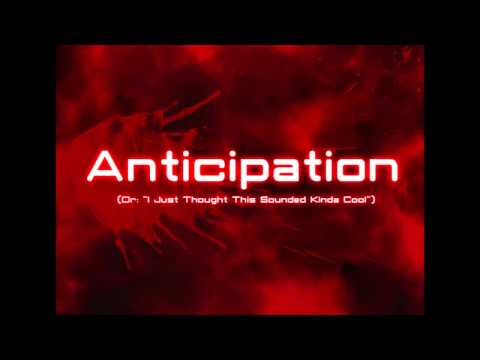



 Most similar audios based on Pinecone vector search: 




1.


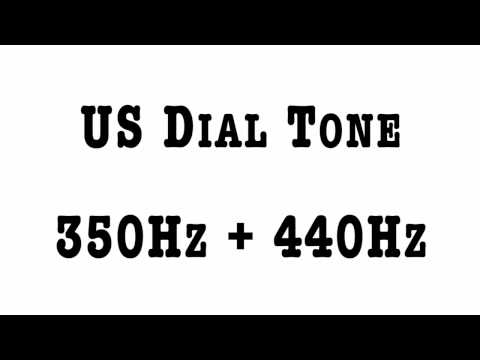


2.


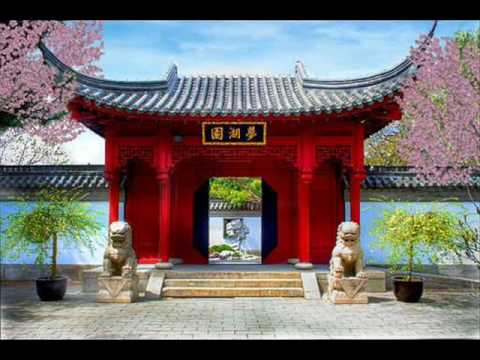


3.


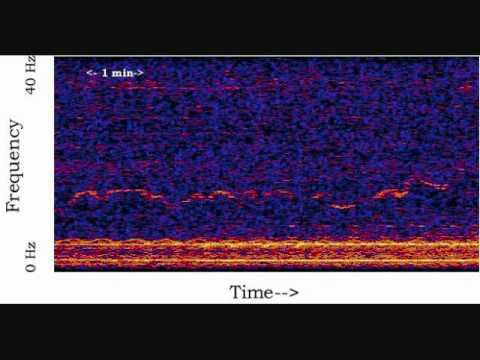




 (Example 2)
 Audio example: https://www.youtube.com/watch?v=rTbY6xcjV34&t=510



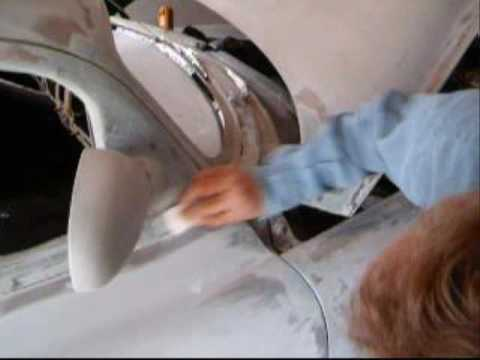



 Most similar audios based on Pinecone vector search: 




1.


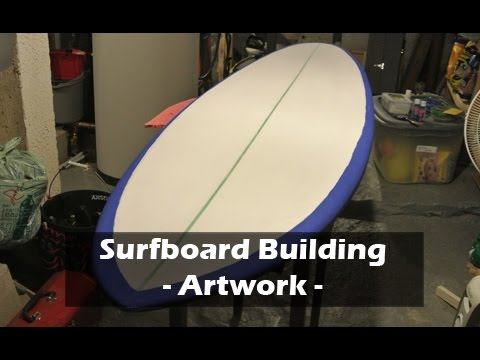


2.


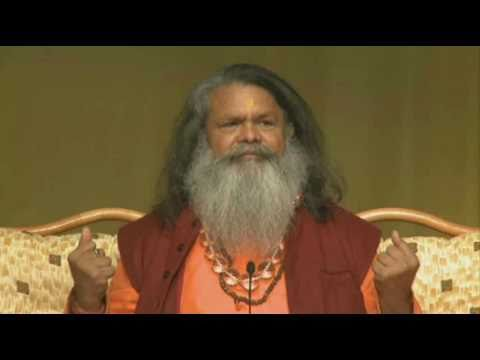


3.


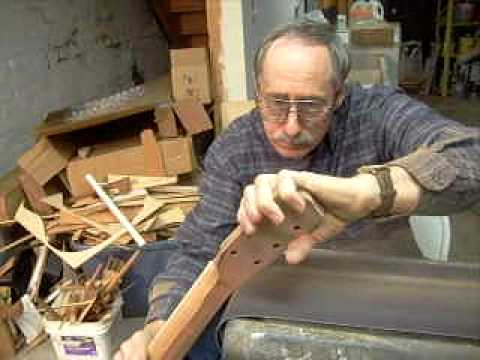




 (Example 3)
 Audio example: https://www.youtube.com/watch?v=jfxTOlXF3Kk&t=100



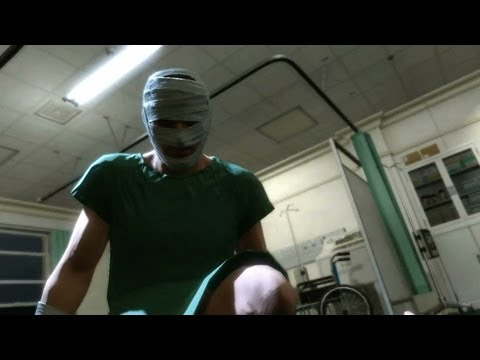



 Most similar audios based on Pinecone vector search: 




1.


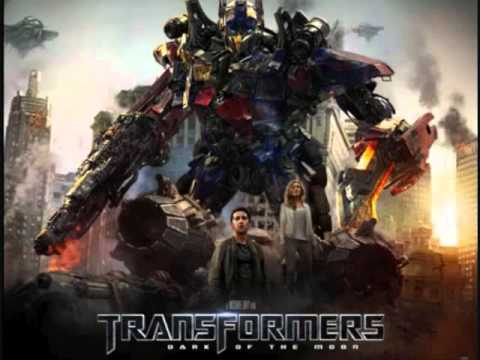


2.


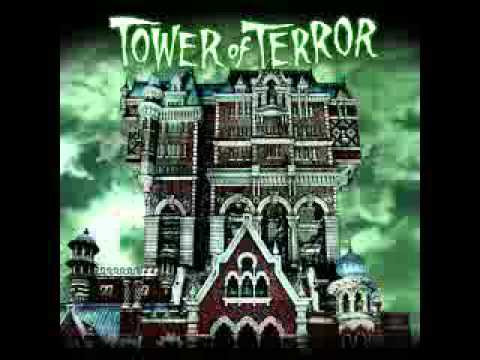


3.


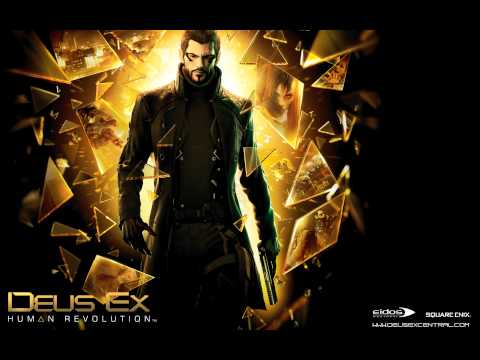

In [21]:
for i, test_audio in enumerate(test_audios):
    vn = '_'.join(test_audio[0].split('_', -2)[:-2])
    vs = test_audio[0].split('_', -2)[-2]

    vs = int(float(vs))
    print(f'\n\n\n (Example {i+1})\n Audio example: https://www.youtube.com/watch?v={vn}&t={vs}\n')
    display(play_video(vn, vs))
    get_similar_audios(test_audio[1])

Once finished with testing, delete the embeddings list to free up the RAM.

In [22]:
items_to_upload.clear()

## Test on an arbitrary wav file

Here we pick arbitrary audio recording, transform it into vector embeddings, query our index, and present the related YouTube videos.

Clone a repository which we will use to preprocess a wav file.

In [23]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 63918, done.
remote: Counting objects: 100% (774/774), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 63918 (delta 603), reused 754 (delta 593), pack-reused 63144
Receiving objects: 100% (63918/63918), 574.93 MiB | 8.95 MiB/s, done.
Resolving deltas: 100% (44648/44648), done.


Download models and parameters needed for preprocessing.

In [24]:
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt -q --show-progress
!wget https://storage.googleapis.com/audioset/vggish_pca_params.npz -q --show-progress

vggish_model.ckpt   100%[===================>] 277.62M  26.8MB/s    in 11s     
vggish_pca_params.n 100%[===================>]  71.31K  --.-KB/s    in 0.001s  


Download the test file.

In [25]:
!curl -o sample-file.wav https://storage.googleapis.com/audioset/yamalyzer/audio/acoustic-guitar.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2411k  100 2411k    0     0  3693k      0 --:--:-- --:--:-- --:--:-- 3693k


In [26]:
# Define wav file name parameter
wav_file_name = 'sample-file.wav'

In [27]:
# Listen to the wav file
Audio(wav_file_name)

Create a .tfrecord file that contains embeddings for our sample wav file.

In [28]:
%%capture
!python models/research/audioset/vggish/vggish_inference_demo.py --wav_file "$wav_file_name" --tfrecord_file "sample-audio.tfrecord"

**Create embeddings**

In [29]:
# Create embeddings from tfrecord file
raw_dataset = tf.data.TFRecordDataset("sample-audio.tfrecord")

for raw_record in raw_dataset.take(1):
    example = tf.train.SequenceExample()
    example.ParseFromString(raw_record.numpy())

In [30]:
audio_frame = []

# We used 10 frames in uploaded audios
# Query vector must have the same dimensions
for i in range(10):
    audio_frame.append(np.frombuffer(example.feature_lists.feature_list["audio_embedding"].feature[i].bytes_list.value[0], dtype=np.int8))

audio_frame = np.array(audio_frame,  dtype=np.float32)
sample_embedding = audio_frame.flatten().tolist()

**Query**

Here we perform the query using the recording's vector embeddings and present the related YouTube videos. Recall that we care about the audio of these videos and observe the audios' similarity to the query's audio. 


 Test audio file:





 Most similar audios based on Pinecone vector search: 




1.


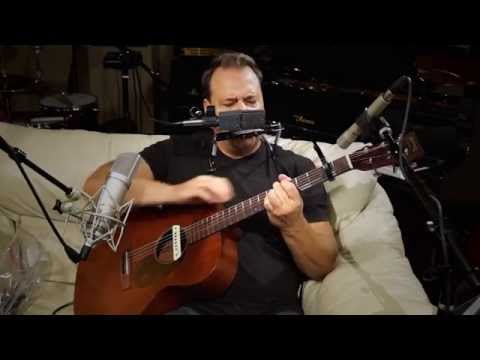


2.


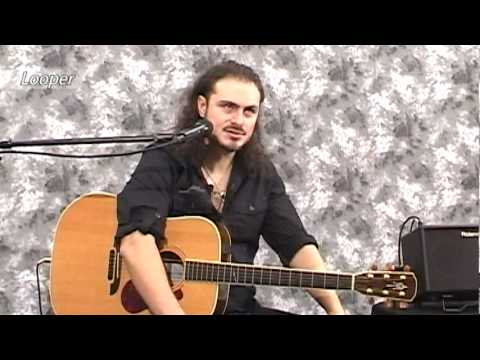


3.


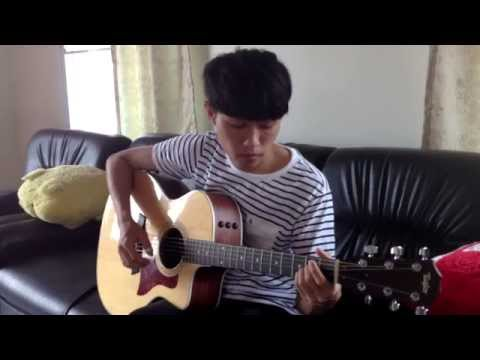


4.


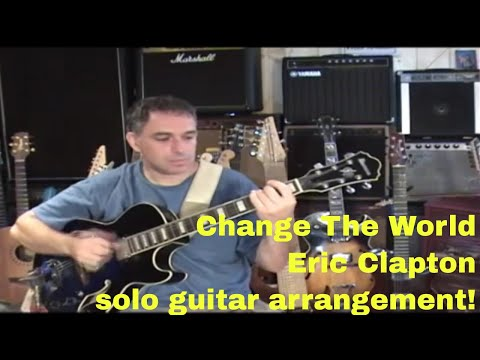


5.


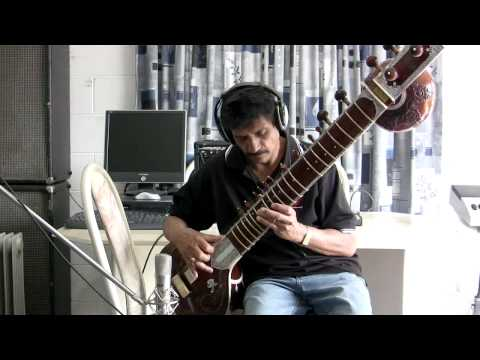

In [31]:
# Query the vector index and display the results
query_results = index.query(queries=[sample_embedding], top_k=10)

print('\n Test audio file:\n')
display(Audio(wav_file_name))

result = query_results.results[0].matches
ids = [res.id for res in result]
scores = [res.score for res in result]
df_result = pd.DataFrame({
              'id':['_'.join(id.split('_', -2)[:-2]) for id in ids], 
              'start_time': [str(id.split('_')[-2]) for id in ids],
              'end_time': [str(id.split('_')[-1]) for id in ids],
              'score': scores,
              'url': ['https://www.youtube.com/watch?v={}&t={}'.format('_'.join(id.split('_')[:-2]), 
                                                                  int(float(id.split('_')[-2]))) for id in ids]})

df_result = df_result[df_result['id'].map(check_video_url) == True].reset_index(drop=True)[:5]
df_result.index += 1 
df_result_styler = df_result.style.format({'url': make_clickable})
print('\n\n Most similar audios based on Pinecone vector search: \n')
display(df_result_styler)
        
for i, row in df_result.iterrows():
    print(f'\n{(i)}.')
    display(play_video(row.id, int(float(row.start_time))))

## Delete the Index
Delete the index once you are sure that you do not want to use it anymore. Once the index is deleted, you cannot use it again.




In [32]:
pinecone.delete_index(index_name)